# CS145: Project 3 | Taxi Trip Count and Tips Prediction

**Authors:**

Please list the names and SUNet IDs of your collaborators below:
* *Name: Liu Jiang, SUNet ID: cacikong*
* *Name: Sizhuo Zhang, SUNet ID: sizhuo*

**Project Overview**

Which elements contribute to the large nunmber of taxi trips count in Chicago? In this project, we focused on several elements(including external elements such as time, location, weather, air quality and internal elements such as people's sentiment brought by events) that influence the taxi trip count in Chicago.

---

# Part 1: Analysis of Dataset

---

The data we use for this project comes from 4 different datasets on BigQuery:

1.Chicago taxi trips dataset: 1 table, 67.71 GB

2.US Environmental Protection Agency's Air Quality and Temperature dataset: 5 tables, 9.05 GB

3.GDELT (Global Database of Events, Language, and Tone) online events dataset: 1 table, 226.52 GB




## Chicago Taxi Trips Table

Each tuple in *bigquery-public-data:chicago_taxi_trips.taxi_trips* represents a unique taxi trip occurred between 2013.1.1 and 2019.11.1. Tuples are uniquely identified by the *unique_key* attribute. This table contains information about when a trip starts and ends, the mileage of the trip, pickup_community_area, dropoff_community_area, fare and tips of the trip, the company from which the taxi is, pickup location, dropoff location. We can use this table to analyze how to arrange distribution of taxi in different time and location to help company earn profits to the largest extent. Also, this table can be joined with events dataset to explore the relationship between trips count/tips and people's sentiment brought by events.

## Air Quality and Temperature Dataset:

Each tuple in *bigquery-public-data:epa_historical_air_quality.temperature_daily_summary* includes information about daily arithmetic mean value of temperature in different location between 1990.1.1 and 2017.12.31. Tuples are uniquely identified by state_code, country_code, site_num and local_date. We can join it with taxi trips table to explore the relationship between trips count and temperature in Chicago.

There are 4 tables we need in historical air quality dataset. They are pretty similar in structure. Take pm10 table as an example. This table includes information about daily arithmetic mean of pm10 in different time and location. We can join it with taxi trips table to explore the relationship between trips count and air quality in Chicago.

## GDELT online events dataset:

Each tuple in *gdelt-bq:full.events* represents detail information about each distinct event occurring from 1979 through Nov 26th, 2019 including date, month, year, number of articles, avgTone, and GoldsteinScale etc. We can create a metric to evaluate how important a day is in terms of people's sentiment brought by events: number of articles * ABS(avgTone) * GoldsteinScale. Tuples are uniquely identified by GLOBALEVENTID. We can use this table to analyze how events impact the usage of taxi in Chicago by joining with taxi trips table.

---

# Part 2: Internal Features Exploration and Visualization

----

In [0]:
# BigQuery Authentication
from google.colab import auth
auth.authenticate_user()
project_id = "proj3-sizhuo"

In [0]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [0]:
# Add import for visualization library
import matplotlib.pyplot as plt
%matplotlib inline

# Add import to calculate mean for the purpose of visualization
import numpy as np 

# A: Temporal Characteristics of Taxi Trips

The following figures look at the relationship between the average number of taxi trips that occur over different temporal scales, which are hour of day, day of week, month of the year and day in a year. As our research question focuses on taxi companies' revenues, pick up time when the trip occurs is adopted for time series analysis.

## Taxi Trips Duration (Rank-size Distribution)
It is acknowledged that taxi fares are usually positively linked with trip distance as well as trip duration. If you spend longer on a taxi for a trip, it is likely for you to be charged more on the fare. Before we dive into revenue analysis, it is important to look at the average duration per trip for each company, in order to know which companies are likely to make more profits per trip. We will reveal more details about popular companies in the latter section.

In [0]:
%%bigquery --project $project_id qTripDuration

SELECT company, ROUND(AVG(trip_seconds)/60, 2)AS avg_minutes
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY company
ORDER BY avg_minutes DESC

(0, 35)

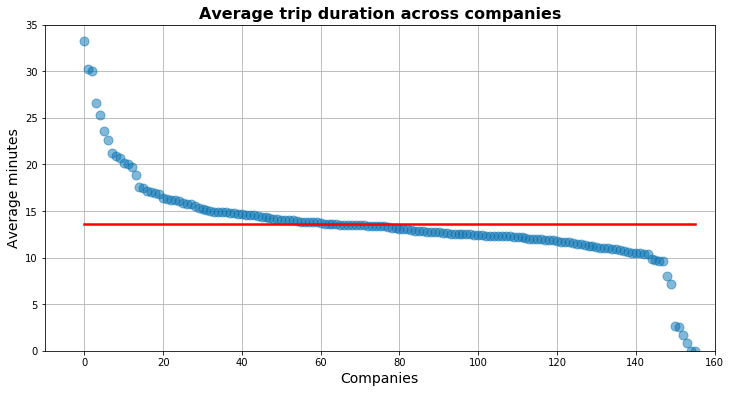

In [0]:
plt.figure(figsize=(12, 6))
plt.grid(zorder=0)
n = len(qTripDuration["company"])
x_pos = list(range(0, n))
avg = np.mean(np.asarray(qTripDuration["avg_minutes"]))
y_avg = [avg]*n
plt.scatter(x_pos, qTripDuration["avg_minutes"], c='#0570B0', alpha=.5, s=80, zorder=2)
plt.plot(x_pos, y_avg, c='r', linewidth=2.5, zorder=4)
plt.title("Average trip duration across companies", fontsize=16, fontweight='bold')
plt.xlabel("Companies", fontsize=14)
plt.ylabel("Average minutes", fontsize=14)
plt.xlim([-10, 160])
plt.ylim([0, 35])

In [0]:
qTripDuration.head(10)

,company,avg_minutes
0,3669 - 85800 Jordan Taxi Inc,33.25
1,"2241 - 44667 - Felman Corp, Manuel Alonso",30.21
2,2241 - 44667 Manuel Alonso,30.03
3,2823 - 73307 Lee Express Inc,26.61
4,2241 - Manuel Alonso,25.29
5,Petani Cab Corp,23.56
6,U Taxicab,22.57
7,2823 - 73307 Seung Lee,21.26
8,2823 - Seung Lee,20.86
9,4053 - 40193 Adwar H. Nikola,20.64


## Taxi Trips by Hour of Day

In [0]:
%%bigquery --project $project_id qTripHour

SELECT hour, AVG(num_trips) AS avg_trips
FROM(
  SELECT EXTRACT(HOUR FROM trip_start_timestamp) as hour, COUNT(*) as num_trips
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  WHERE trip_seconds IS NOT NULL
  AND trip_miles IS NOT NULL
  AND pickup_community_area IS NOT NULL
  AND dropoff_community_area IS NOT NULL
  AND trip_total IS NOT NULL
  AND company IS NOT NULL
  GROUP BY EXTRACT(YEAR FROM trip_start_timestamp), EXTRACT(MONTH FROM trip_start_timestamp), EXTRACT(DAY FROM trip_start_timestamp), EXTRACT(HOUR FROM trip_start_timestamp)
)
GROUP BY hour
ORDER BY hour

(0, 4000)

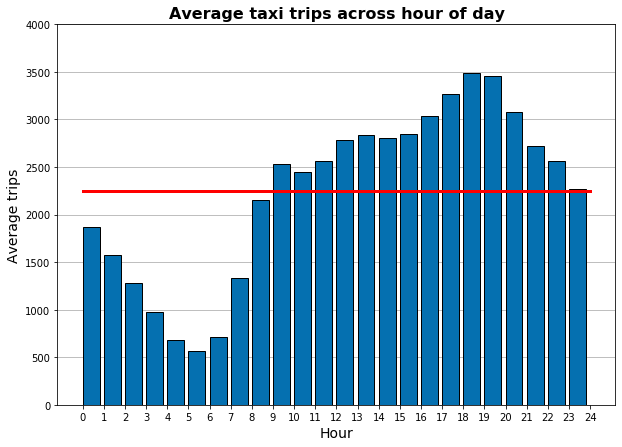

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(axis='y', zorder=0)
x_pos = list(range(0, 25))
avg = np.mean(np.asarray(qTripHour["avg_trips"]))
y_avg = [avg]*len(x_pos)
plt.bar(qTripHour["hour"], qTripHour["avg_trips"], align='edge', edgecolor='black',color='#0570B0', zorder=2)
plt.plot(x_pos, y_avg, c='r', linewidth=3, zorder=3)
plt.title("Average taxi trips across hour of day", fontsize=16, fontweight='bold')
plt.xticks(x_pos)
plt.xlabel("Hour", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.ylim([0, 4000])

## Taxi Trips by Day of Week

In [0]:
%%bigquery --project $project_id qTripDay

SELECT day, AVG(num_trips) AS avg_trips
FROM(
  SELECT EXTRACT(DAYOFWEEK FROM trip_start_timestamp) as day, COUNT(*) as num_trips
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  WHERE trip_seconds IS NOT NULL
  AND trip_miles IS NOT NULL
  AND pickup_community_area IS NOT NULL
  AND dropoff_community_area IS NOT NULL
  AND trip_total IS NOT NULL
  AND company IS NOT NULL
  GROUP BY EXTRACT(YEAR FROM trip_start_timestamp), EXTRACT(WEEK FROM trip_start_timestamp), EXTRACT(DAYOFWEEK FROM trip_start_timestamp)
)
GROUP BY day
ORDER BY day

(0, 70000)

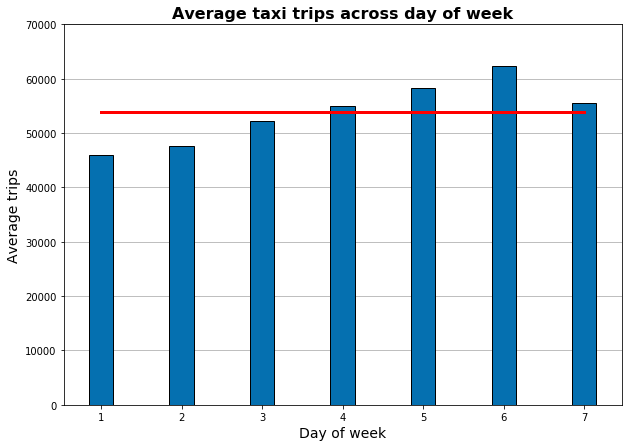

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(axis='y', zorder=0)
x_pos = list(range(1, 8))
avg = np.mean(np.asarray(qTripDay["avg_trips"]))
y_avg = [avg]*len(x_pos)
plt.bar(qTripDay["day"], qTripDay["avg_trips"], align='center', edgecolor='black',color='#0570B0', width=0.3, zorder=2)
plt.plot(x_pos, y_avg, c='r', linewidth=3, zorder=3)
plt.title("Average taxi trips across day of week", fontsize=16, fontweight='bold')
plt.xticks(x_pos)
plt.xlabel("Day of week", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.ylim([0, 70000])

## Taxi Trips by Month

In [0]:
%%bigquery --project $project_id qTripMonth

SELECT month, AVG(num_trips) AS avg_trips
FROM(
  SELECT EXTRACT(MONTH FROM trip_start_timestamp) as month, COUNT(*) as num_trips
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  WHERE trip_seconds IS NOT NULL
  AND trip_miles IS NOT NULL
  AND pickup_community_area IS NOT NULL
  AND dropoff_community_area IS NOT NULL
  AND trip_total IS NOT NULL
  AND company IS NOT NULL
  GROUP BY EXTRACT(YEAR FROM trip_start_timestamp), EXTRACT(MONTH FROM trip_start_timestamp)
)
GROUP BY month
ORDER BY month

(0, 2000000)

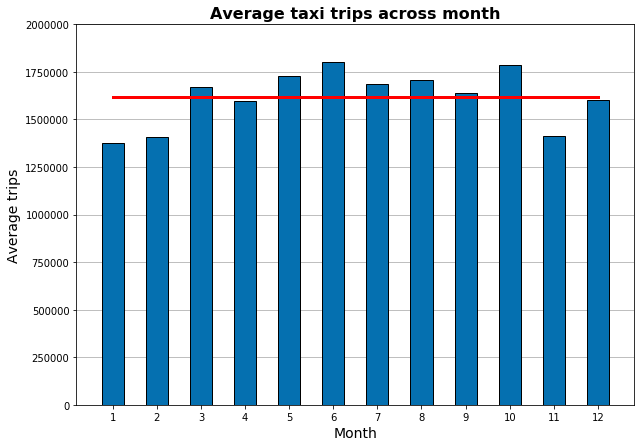

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(axis='y', zorder=0)
x_pos = list(range(1, 13))
avg = np.mean(np.asarray(qTripMonth["avg_trips"]))
y_avg = [avg]*len(x_pos)
plt.bar(qTripMonth["month"], qTripMonth["avg_trips"], align='center', edgecolor='black',color='#0570B0', width=0.5, zorder=2)
plt.plot(x_pos, y_avg, c='r', linewidth=3, zorder=3)
plt.title("Average taxi trips across month", fontsize=16, fontweight='bold')
plt.xticks(x_pos)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.ylim([0, 2000000])

## Taxi Trips by Day of Year

In [0]:
%%bigquery --project $project_id qTripDayYear

SELECT day, AVG(num_trips) AS avg_trips
FROM(
  SELECT EXTRACT(DAYOFYEAR FROM trip_start_timestamp) as day, COUNT(*) as num_trips
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  WHERE trip_seconds IS NOT NULL
  AND trip_miles IS NOT NULL
  AND pickup_community_area IS NOT NULL
  AND dropoff_community_area IS NOT NULL
  AND trip_total IS NOT NULL
  AND company IS NOT NULL
  GROUP BY EXTRACT(YEAR FROM trip_start_timestamp), EXTRACT(DAYOFYEAR FROM trip_start_timestamp)
)
GROUP BY day
ORDER BY day

(0, 80000)

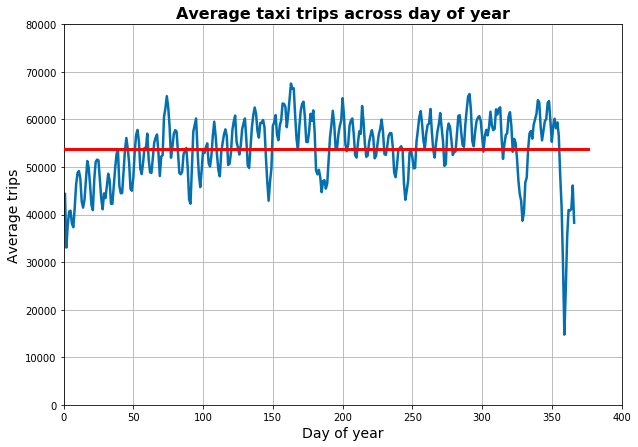

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
x_pos = list(range(1, 377))
avg = np.mean(np.asarray(qTripDayYear["avg_trips"]))
y_avg = [avg]*len(x_pos)
plt.plot(qTripDayYear["day"], qTripDayYear["avg_trips"], c='#0570B0', linewidth=2.5, zorder=2)
plt.plot(x_pos, y_avg, c='r', linewidth=3, zorder=3)
plt.title("Average taxi trips across day of year", fontsize=16, fontweight='bold')
plt.xlabel("Day of year", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.xlim([0, 400])
plt.ylim([0, 80000])

## Taxi Trips by Year

In [0]:
%%bigquery --project $project_id qDateRange

SELECT MIN(DATE(trip_start_timestamp)) AS earliest, MAX(DATE(trip_start_timestamp)) AS latest
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`

In [0]:
qDateRange.head()

,earliest,latest
0,2013-01-01,2019-11-01


In [0]:
%%bigquery --project $project_id qTripYear

SELECT EXTRACT(YEAR FROM trip_start_timestamp) as year, COUNT(*) as num_trips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY EXTRACT(YEAR FROM trip_start_timestamp)

(0, 25000000.0)

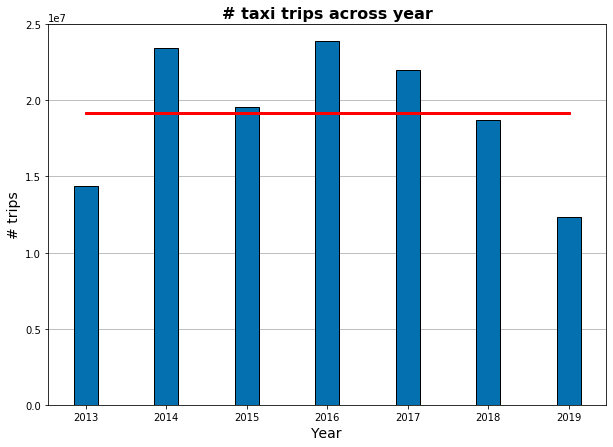

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(axis='y', zorder=0)
avg = np.mean(np.asarray(qTripYear["num_trips"]))
y_avg = [avg]*len(qTripYear["year"])
plt.bar(qTripYear["year"], qTripYear["num_trips"], align='center', edgecolor='black',color='#0570B0', width=0.3, zorder=2)
plt.plot(qTripYear["year"], y_avg, c='r', linewidth=3, zorder=3)
plt.title("# taxi trips across year", fontsize=16, fontweight='bold')
plt.xlabel("Year", fontsize=14)
plt.ylabel("# trips", fontsize=14)
plt.ylim([0, 2.5e+7])

The graphs above reveal the temporal trends over different time scales. As for the figure which visualizes average taxi trips across hours of a day, the number of taxi trips declines from at night and reaches its minimal at 5 am, which makes sense as people travel less during nighttime. The morning peak occurs at 9 am. Travel demand gradually rises since 3 pm and peaks at 6 pm. More people choose taxi as transportation means after work. Regarding day of week, it is noteworthy that taxi trip count peaks at Friday. However, there is not remarkable trend in terms of months. As for day of year significant fall of trip quantity occurs around Christmas and New Year holidays. One of the most interesting patterns are produced by the comparison across different years. Even though the figure from 2019 should be ignored in the analysis as data of this year may not be complete, the number of taxi trips drops notably since 2017, which can be interpreted that taxi has enjoyed decreasing popularity over these years. This trend causes us to think about what transit modes are substituting taxi (e.g. private automobile ridesharing or public transit)?

# B: Taxi Trips and Spatial Characteristics
This section sheds light into the average number of taxi trips per day based on different locations. Chicago community area has been chosen as the geographic unit in the analysis, as its granularity provides substantial geographic contexts yet less sentivity to population change. 

## Taxi Trips Distance (Rank-size Distribution)

In [0]:
%%bigquery --project $project_id qDistanceCompany

SELECT company, AVG(trip_miles*1.60934) AS avg_distance
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY company
ORDER BY avg_distance DESC

(0, 18)

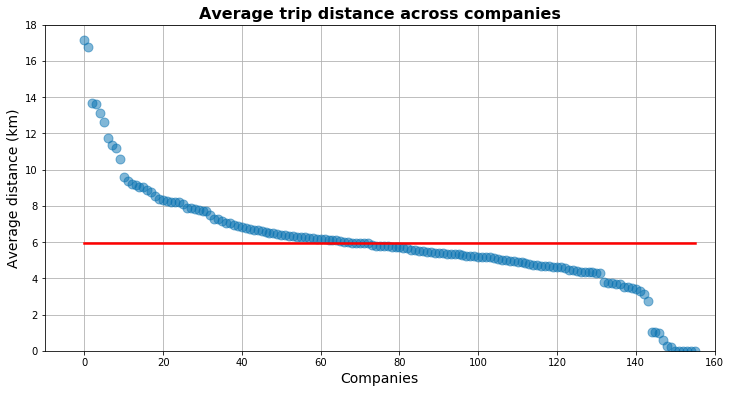

In [0]:
plt.figure(figsize=(12, 6))
plt.grid(zorder=0)
n = len(qDistanceCompany["company"])
x_pos = list(range(0, n))
avg = np.mean(np.asarray(qDistanceCompany["avg_distance"]))
y_avg = [avg]*n
plt.scatter(x_pos, qDistanceCompany["avg_distance"], c='#0570B0', alpha=.5, s=80, zorder=2)
plt.plot(x_pos, y_avg, c='r', linewidth=2.5, zorder=4)
plt.title("Average trip distance across companies", fontsize=16, fontweight='bold')
plt.xlabel("Companies", fontsize=14)
plt.ylabel("Average distance (km)", fontsize=14)
plt.xlim([-10, 160])
plt.ylim([0, 18])

In [0]:
qDistanceCompany.head(10)

,company,avg_distance
0,2241 - 44667 Manuel Alonso,17.130460
1,"2241 - 44667 - Felman Corp, Manuel Alonso",16.754137
2,2823 - 73307 Lee Express Inc,13.677136
3,Petani Cab Corp,13.604287
4,4053 - 40193 Adwar H. Nikola,13.127968
5,U Taxicab,12.629498
6,2241 - Manuel Alonso,11.749166
7,1408 - 89599 Donald Barnes,11.372060
8,2823 - 73307 Seung Lee,11.211252
9,2823 - Seung Lee,10.611715


## Taxi Trips by Location

In [0]:
%%bigquery --project $project_id qTripLoc

SELECT pickup_community_area, AVG(num_trips) AS avg_trips
FROM(SELECT pickup_community_area, COUNT(*) AS num_trips
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  WHERE trip_seconds IS NOT NULL
  AND trip_miles IS NOT NULL
  AND pickup_community_area IS NOT NULL
  AND dropoff_community_area IS NOT NULL
  AND trip_total IS NOT NULL
  AND company IS NOT NULL
  GROUP BY EXTRACT(YEAR FROM trip_start_timestamp), EXTRACT(DAYOFYEAR FROM trip_start_timestamp), pickup_community_area)
GROUP BY pickup_community_area

(0, 80)

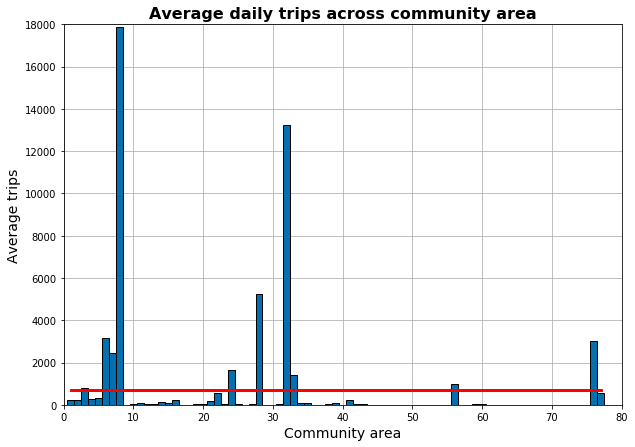

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
avg = np.mean(np.asarray(qTripLoc["avg_trips"]))
y_avg = [avg]*len(qTripLoc["avg_trips"])
plt.bar(qTripLoc["pickup_community_area"], qTripLoc["avg_trips"], align='center', edgecolor='black', width=1, color='#0570B0', zorder=2)
plt.plot(qTripLoc["pickup_community_area"], y_avg, c='r', linewidth=3, zorder=3)
plt.title("Average daily trips across community area", fontsize=16, fontweight='bold')
plt.xlabel("Community area", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.ylim([0, 18000])
plt.xlim([0, 80])

## Trip Distance by Location

In [0]:
%%bigquery --project $project_id qDistanceLoc

SELECT pickup_community_area, AVG(trip_miles) AS avg_distance
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY pickup_community_area

(0, 14)

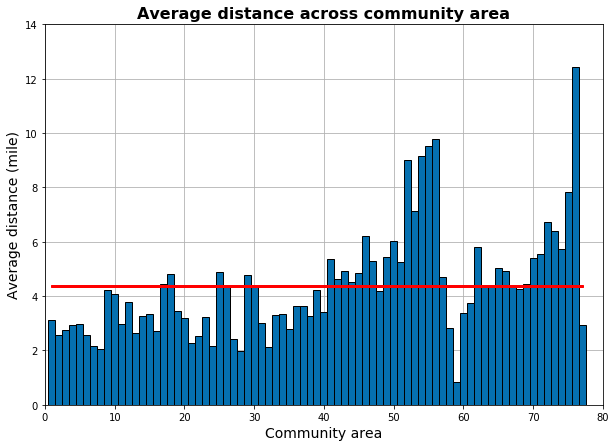

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
avg = np.mean(np.asarray(qDistanceLoc["avg_distance"]))
y_avg = [avg]*len(qDistanceLoc["avg_distance"])
plt.bar(qDistanceLoc["pickup_community_area"], qDistanceLoc["avg_distance"], align='center', edgecolor='black', width=1, color='#0570B0', zorder=2)
plt.plot(qDistanceLoc["pickup_community_area"], y_avg, c='r', linewidth=3, zorder=3)
plt.title("Average distance across community area",fontsize=16,fontweight='bold')
plt.xlabel("Community area", fontsize=14)
plt.ylabel("Average distance (mile)", fontsize=14)
plt.xlim([0, 80])
plt.ylim([0, 14])

The chart showing average trip distance across companies indicates that some companies may focus on sending out "longer" trips while others mainly serve "shorter" trips. Different specializations in longer or shorter trips may be those companies' own revenue strategies.

The chart displaying average daily trips for each community area demonstrates that the distribution is extremely uneven across different locations. That means actually a very small number of community area sends out the majority of trips, and others are significantly less popular. Thus, taxi trips usually occur in localized regions. From the chart which detail the relationship between average trip distance and community area, the unevenness is not as significant as previous one. However, it if clear that top 2 popular community areas in the previous chart mainly send trips with distance below average. It is interesting that one of popular community areas which is No. 75 has most trips very long in distance. We speculate that this community area is very likely to have any major functional infrastructure but far from downtown, such as airport.

# C: Company Market Share
This section looks at the market share of taxi companies in Chicago, by differentiating their corresponding percentage of taxi trip count and total fares collected in trip.

## Taxi trips and Company (Rank-size Distribution)

In [0]:
%%bigquery --project $project_id qTripCompany

SELECT company, COUNT(unique_key) AS num_trips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY company
ORDER BY num_trips DESC
LIMIT 50

(0, 40000000.0)

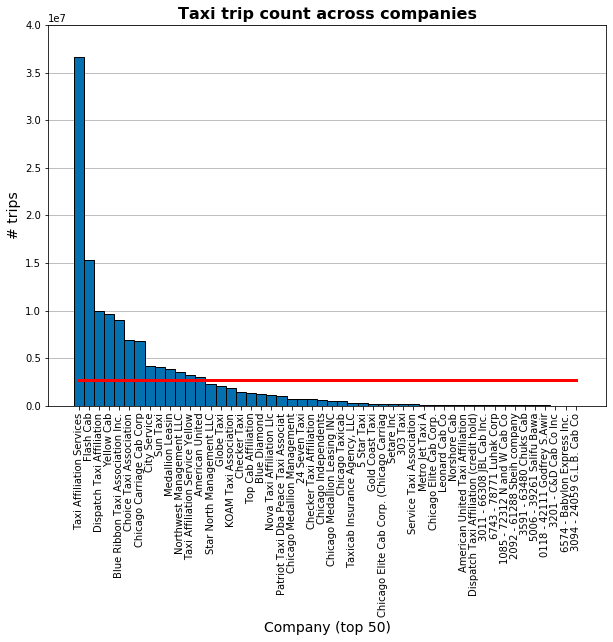

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(axis='y', zorder=0)
topk = 50
x_pos = list(range(0, topk))
avg = np.mean(np.asarray(qTripCompany["num_trips"]))
y_avg = [avg]*len(qTripCompany["num_trips"])
plt.bar(x_pos, qTripCompany["num_trips"], align='center', edgecolor='black', width=1, color='#0570B0', zorder=2)
plt.plot(x_pos, y_avg, c='r', linewidth=3, zorder=3)
plt.title("Taxi trip count across companies",fontsize=16,fontweight='bold')
plt.xlabel("Company (top 50)", fontsize=14)
plt.xticks(x_pos, qTripCompany["company"], rotation='vertical')
plt.ylabel("# trips", fontsize=14)
plt.ylim([0, 4e+7])

In [0]:
%%bigquery --project $project_id qTripCompanyPercent

SELECT company, ROUND(COUNT(unique_key)/(SELECT COUNT(*) FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` WHERE trip_seconds IS NOT NULL AND trip_miles IS NOT NULL AND pickup_community_area IS NOT NULL AND dropoff_community_area IS NOT NULL AND trip_total IS NOT NULL AND company IS NOT NULL)*100, 2) AS trip_percentage
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY company
ORDER BY trip_percentage DESC
LIMIT 50

(0, 30)

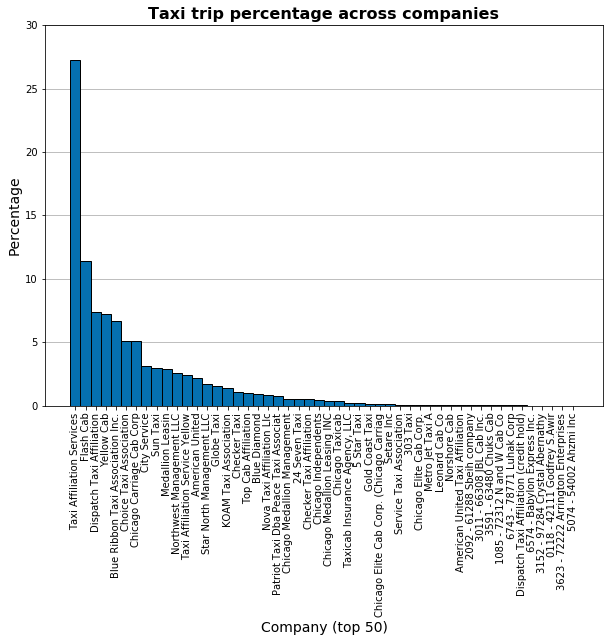

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(axis='y', zorder=0)
topk = 50
x_pos = list(range(0, topk))
avg = np.mean(np.asarray(qTripCompanyPercent["trip_percentage"]))
y_avg = [avg]*len(qTripCompanyPercent["trip_percentage"])
plt.bar(x_pos, qTripCompanyPercent["trip_percentage"], align='center', edgecolor='black', width=1, color='#0570B0', zorder=2)
plt.title("Taxi trip percentage across companies",fontsize=16,fontweight='bold')
plt.xlabel("Company (top 50)", fontsize=14)
plt.xticks(x_pos, qTripCompanyPercent["company"], rotation='vertical')
plt.ylabel("Percentage", fontsize=14)
plt.ylim([0, 30])

## Taxi Fares and Company (Rank-size Distribution)
In a taxi trip, as tolls are collected by the government, calculated fares that go into taxi company will subtract tolls.

In [0]:
%%bigquery --project $project_id qFareCompany

SELECT company, SUM(trip_total-tolls) AS revenue
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY company
ORDER BY revenue DESC
LIMIT 50

(0, 550000000.0)

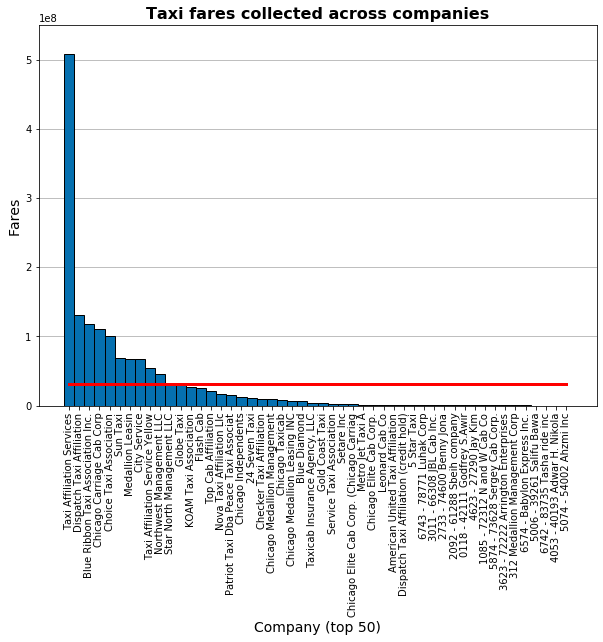

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(axis='y', zorder=0)
topk = 50
x_pos = list(range(0, topk))
avg = np.mean(np.asarray(qFareCompany["revenue"]))
y_avg = [avg]*len(qFareCompany["revenue"])
plt.bar(x_pos, qFareCompany["revenue"], align='center', edgecolor='black', width=1, color='#0570B0', zorder=2)
plt.plot(x_pos, y_avg, c='r', linewidth=3, zorder=3)
plt.title("Taxi fares collected across companies",fontsize=16,fontweight='bold')
plt.xlabel("Company (top 50)", fontsize=14)
plt.xticks(x_pos, qFareCompany["company"], rotation='vertical')
plt.ylabel("Fares", fontsize=14)
plt.ylim([0, 5.5e+8])

## Taxi Fares and Company (Rank-size Distribution)

In [0]:
%%bigquery --project $project_id qFareCompanyPercent

SELECT company, ROUND(SUM(trip_total-tolls)/(SELECT SUM(trip_total-tolls) FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` WHERE trip_seconds IS NOT NULL AND trip_miles IS NOT NULL AND pickup_community_area IS NOT NULL AND dropoff_community_area IS NOT NULL AND trip_total IS NOT NULL AND company IS NOT NULL)*100, 2) AS fare_percentage
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY company
ORDER BY fare_percentage DESC
LIMIT 50

(0, 35)

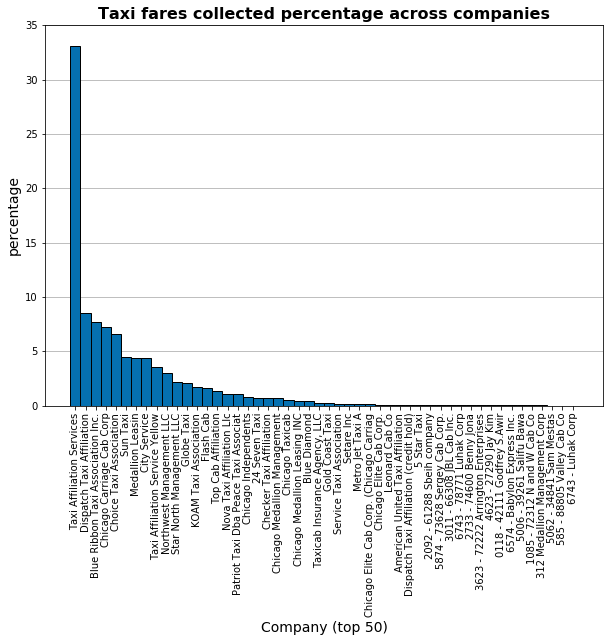

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(axis='y', zorder=0)
topk = 50
x_pos = list(range(0, topk))
avg = np.mean(np.asarray(qFareCompanyPercent["fare_percentage"]))
y_avg = [avg]*len(qFareCompanyPercent["fare_percentage"])
plt.bar(x_pos, qFareCompanyPercent["fare_percentage"], align='center', edgecolor='black', width=1, color='#0570B0', zorder=2)
plt.title("Taxi fares collected percentage across companies",fontsize=16,fontweight='bold')
plt.xlabel("Company (top 50)", fontsize=14)
plt.xticks(x_pos, qFareCompanyPercent["company"], rotation='vertical')
plt.ylabel("percentage", fontsize=14)
plt.ylim([0, 35])

The charts above illustrates close relationship between total collected taxi fares and the share of taxi trip count. The taxi company gaint is Taxi Affiliation Services which take up over 25% trip count and 30% revenues. In order to maximize market share, it is important for a taxi company to think about how to attract more passengers and increase trips.

---

# Part 3: External Features Exploration and Visualization 

---

# D: Taxi Trips and Air Quality

## Taxi Trips and NO2
Extract and store NO2 dataset in Chicago.

In [0]:
model_dataset_name = 'proj3_chicago_taxi'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('proj3-sizhuo', 'proj3_chicago_taxi'))

In [0]:
%%bigquery --project $project_id qChicagoNo2

SELECT date_local, state_code, county_code, city_name, cbsa_name, arithmetic_mean
FROM `bigquery-public-data.epa_historical_air_quality.no2_daily_summary`
WHERE state_name = 'Illinois'
AND city_name = 'Chicago'
AND date_local BETWEEN '2013-01-01' AND '2017-12-31'

In [0]:
qChicagoNo2.head()

,date_local,state_code,county_code,city_name,cbsa_name,arithmetic_mean
0,2014-05-22,17,031,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI",13.833333
1,2014-06-19,17,031,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI",16.083333
2,2014-01-02,17,031,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI",20.708333
3,2014-03-12,17,031,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI",17.437500
4,2014-10-12,17,031,Chicago,"Chicago-Naperville-Elgin, IL-IN-WI",11.083333


In [0]:
%%bigquery --project $project_id qTripNo2

WITH no2 AS (
  SELECT ROUND(AVG(arithmetic_mean)) AS avg_no2, date_local
  FROM `cs145-fa19-254923.proj3_chicago_taxi.no2_daily_summary`
  GROUP BY date_local
), day_no2 AS (
  SELECT CAST(trip_start_timestamp AS date) AS d, COUNT(*) AS num_trips, avg_no2
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  JOIN no2 ON CAST(trip_start_timestamp AS date) = date_local
  GROUP BY CAST(trip_start_timestamp AS date), avg_no2
)
SELECT AVG(num_trips) AS avg_trips, avg_no2
FROM day_no2
GROUP BY avg_no2
ORDER BY avg_no2

(0, 180000)

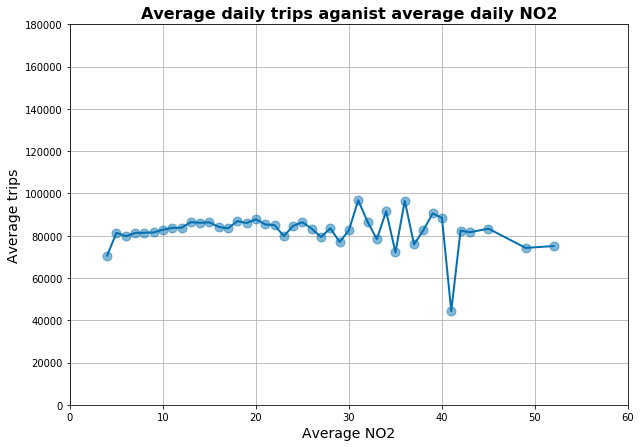

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
plt.scatter(qTripNo2["avg_no2"], qTripNo2["avg_trips"], c='#0570B0', alpha=.5, s=80, zorder=2)
plt.plot(qTripNo2["avg_no2"], qTripNo2["avg_trips"], c='#0570B0', linewidth=2, zorder=4)
plt.title("Average daily trips aganist average daily NO2", fontsize=16, fontweight='bold')
plt.xlabel("Average NO2", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.xlim([0, 60])
plt.ylim([0, 180000])

According to this graph, before NO2 = 30, average trips almost maintain the same and after NO2 = 30, there is an oscillation among trips count. At around NO2 = 40, the trips count falls to the lowest point.

## Taxi Trips and SO2


In [0]:
%%bigquery --project $project_id qChicagoSo2

SELECT date_local, state_code, county_code, city_name, cbsa_name, arithmetic_mean
FROM `bigquery-public-data.epa_historical_air_quality.so2_daily_summary`
WHERE state_name = 'Illinois'
AND city_name = 'Chicago'
AND date_local BETWEEN '2013-01-01' AND '2017-12-31'

In [0]:
%%bigquery --project $project_id qTripSo2

WITH so2 AS (
  SELECT ROUND(AVG(arithmetic_mean)) AS avg_so2, date_local
  FROM `cs145-fa19-254923.proj3_chicago_taxi.so2_daily_summary`
  GROUP BY date_local
), day_so2 AS (
  SELECT CAST(trip_start_timestamp AS date) AS d, COUNT(*) AS num_trips, avg_so2
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  JOIN so2 ON CAST(trip_start_timestamp AS date) = date_local
  GROUP BY CAST(trip_start_timestamp AS date), avg_so2
)
SELECT AVG(num_trips) AS avg_trips, avg_so2
FROM day_so2
GROUP BY avg_so2
ORDER BY avg_so2

(0, 120000)

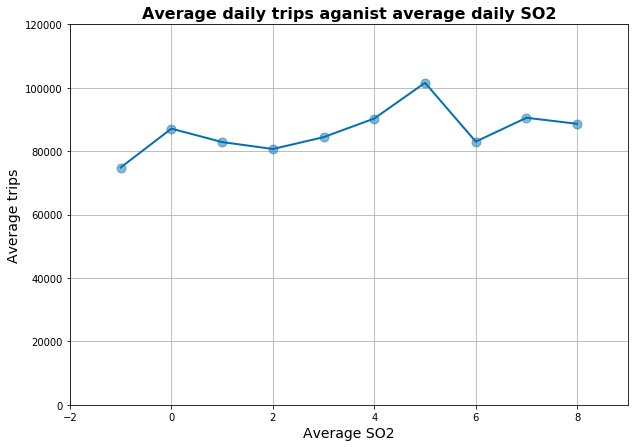

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
plt.scatter(qTripSo2["avg_so2"], qTripSo2["avg_trips"], c='#0570B0', alpha=.5, s=80, zorder=2)
plt.plot(qTripSo2["avg_so2"], qTripSo2["avg_trips"], c='#0570B0', linewidth=2, zorder=4)
plt.title("Average daily trips aganist average daily SO2", fontsize=16, fontweight='bold')
plt.xlabel("Average SO2", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.xlim([-2, 9])
plt.ylim([0, 120000])

From this graph we can see that the peak occurs around SO2 = 5 and overall there seems no distinct correlation between SO2 and trips count.

## Taxi Trips Count and PM2.5

Extract PM2.5 data in Chicago.

In [0]:
%%bigquery --project $project_id qChicagoPm25

SELECT date_local, state_code, county_code, city_name, cbsa_name, arithmetic_mean
FROM `bigquery-public-data.epa_historical_air_quality.pm25_frm_daily_summary`
WHERE state_name = 'Illinois'
AND city_name = 'Chicago'
AND date_local BETWEEN '2013-01-01' AND '2017-12-31'

Explore the relationship between trips count and PM2.5

In [0]:
%%bigquery --project $project_id qTripPm25

WITH pm25 AS (
  SELECT ROUND(AVG(arithmetic_mean)) AS avg_pm25, date_local
  FROM `cs145-fa19-254923.proj3_chicago_taxi.pm25_frm_daily_summary`
  GROUP BY date_local
), day_pm25 AS (
  SELECT CAST(trip_start_timestamp AS date) AS d, COUNT(*) AS num_trips, avg_pm25
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  JOIN pm25 ON CAST(trip_start_timestamp AS date) = date_local
  GROUP BY CAST(trip_start_timestamp AS date), avg_pm25
)
SELECT AVG(num_trips) AS avg_trips, avg_pm25
FROM day_pm25
GROUP BY avg_pm25
ORDER BY avg_pm25

(0, 120000)

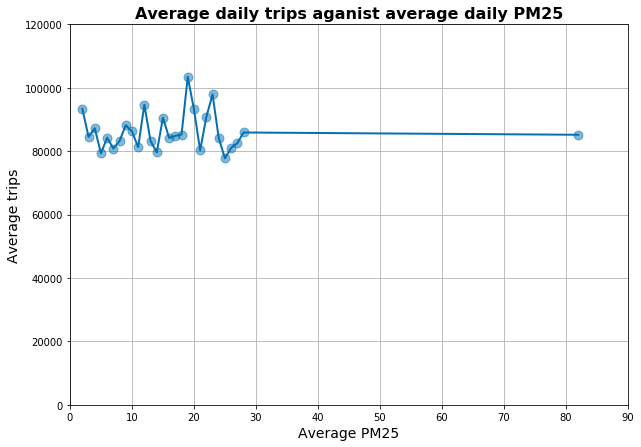

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
plt.scatter(qTripPm25["avg_pm25"], qTripPm25["avg_trips"], c='#0570B0', alpha=.5, s=80, zorder=2)
plt.plot(qTripPm25["avg_pm25"], qTripPm25["avg_trips"], c='#0570B0', linewidth=2, zorder=4)
plt.title("Average daily trips aganist average daily PM25", fontsize=16, fontweight='bold')
plt.xlabel("Average PM25", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.xlim([0, 90])
plt.ylim([0, 120000])

According to this graph, we can see that before pm2.5=30, there is an irregular oscillation in terms of average trip counts and after that there is just a straight line. It is maybe because of the lack of data between pm2.5=30 and 80 so that the straight line shows. And also we can see that there is no distinct relationship between trip counts in Chicago and PM2.5.

## Taxi Trips Count and PM10

Extract PM10 data in Chicago.

In [0]:
%%bigquery --project $project_id qChicagoPm10

SELECT date_local, state_code, county_code, city_name, cbsa_name, arithmetic_mean
FROM `bigquery-public-data.epa_historical_air_quality.pm10_daily_summary`
WHERE state_name = 'Illinois'
AND city_name = 'Chicago'
AND date_local BETWEEN '2013-01-01' AND '2017-12-31'

In [0]:
%%bigquery --project $project_id qTripPm10

WITH pm10 AS (
  SELECT ROUND(AVG(arithmetic_mean)) AS avg_pm10, date_local
  FROM `cs145-fa19-254923.proj3_chicago_taxi.pm10_daily_summary`
  GROUP BY date_local
), day_pm10 AS (
  SELECT CAST(trip_start_timestamp AS date) AS d, COUNT(*) AS num_trips, avg_pm10
  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
  JOIN pm10 ON CAST(trip_start_timestamp AS date) = date_local
  GROUP BY CAST(trip_start_timestamp AS date), avg_pm10
)
SELECT AVG(num_trips) AS avg_trips, avg_pm10
FROM day_pm10
GROUP BY avg_pm10
ORDER BY avg_pm10

(0, 120000)

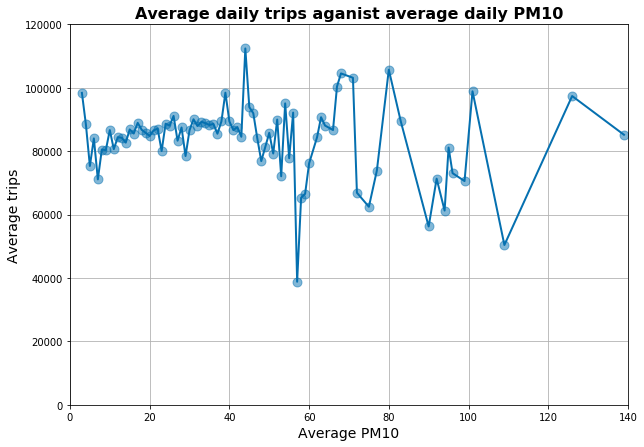

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
plt.scatter(qTripPm10["avg_pm10"], qTripPm10["avg_trips"], c='#0570B0', alpha=.5, s=80, zorder=2)
plt.plot(qTripPm10["avg_pm10"], qTripPm10["avg_trips"], c='#0570B0', linewidth=2, zorder=4)
plt.title("Average daily trips aganist average daily PM10", fontsize=16, fontweight='bold')
plt.xlabel("Average PM10", fontsize=14)
plt.ylabel("Average trips", fontsize=14)
plt.xlim([0, 140])
plt.ylim([0, 120000])

According to this graph, we can see that there is also no distinct relationship between the taxi trips count in Chicago and PM10. The curve oscillates randomly so that there is no strong correlation between the two.

# E: Taxi Tips

## Taxi Trips and Tips

In [0]:
%%bigquery --project $project_id qTripTips

SELECT ROUND(tips) as round_tips, COUNT(*) AS num_trips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE DATE(trip_start_timestamp) <= '2017-12-31'
AND trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY round_tips
ORDER BY round_tips

(0, 1000)

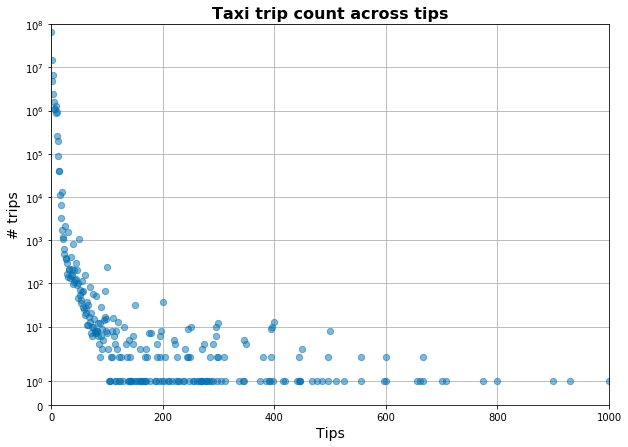

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
plt.scatter(qTripTips["round_tips"], qTripTips["num_trips"], c='#0570B0', alpha=.5, s=40, zorder=2)
plt.title("Taxi trip count across tips", fontsize=16, fontweight='bold')
plt.xlabel("Tips", fontsize=14)
plt.ylabel("# trips", fontsize=14)
plt.yscale('symlog')
plt.ylim([0, 1e+8])
plt.xlim([0, 1000])

According to this graph, the number of trips decreases sharply with tips increasing.

## Tips and Trip Distance

In [0]:
%%bigquery --project $project_id qTipDistance

SELECT ROUND(trip_miles) AS trip_distance, AVG(tips) AS avg_tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE DATE(trip_start_timestamp) <= '2017-12-31'
AND trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY trip_distance
ORDER BY trip_distance

(-2, 40)

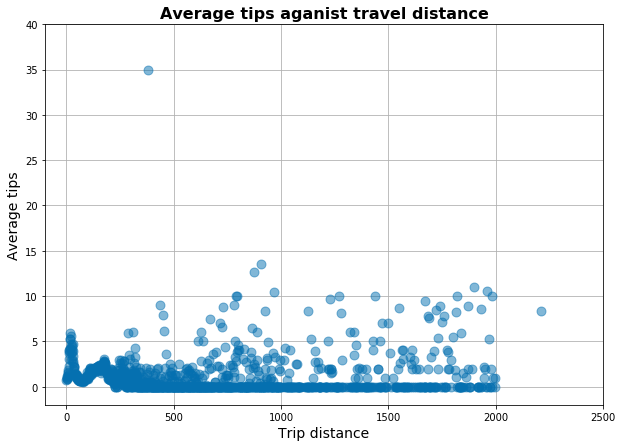

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
plt.scatter(qTipDistance["trip_distance"], qTipDistance["avg_tips"], c='#0570B0', alpha=.5, s=80, zorder=2)
plt.title("Average tips aganist travel distance", fontsize=16, fontweight='bold')
plt.xlabel("Trip distance", fontsize=14)
plt.ylabel("Average tips", fontsize=14)
plt.xlim([-100, 2500])
plt.ylim([-2, 40])

It seems like there is no strong correlation between tips and trip distance.

## Sentiment of Day

In [0]:
%%bigquery --project $project_id qSentimentDay

SELECT FORMAT_TIMESTAMP("%Y-%m-%d", 
PARSE_TIMESTAMP("%Y%m%d", cast(t1.SQLDATE as string) )) AS SQLDATE, AVG(t1.NumArticles*ABS(t1.AvgTone)* t1.GoldsteinScale/t2.sumPerMonth)*1000000 AS index
FROM `gdelt-bq.full.events` t1, 
(SELECT MonthYear, SUM( NumArticles) AS sumPerMonth
FROM `gdelt-bq.full.events`
GROUP BY MonthYear) t2
WHERE t1.MonthYear = t2.MonthYear
AND t1.SQLDATE BETWEEN 20130101 AND 20171213
GROUP BY SQLDATE
ORDER BY SQLDATE 

(0, 1807)

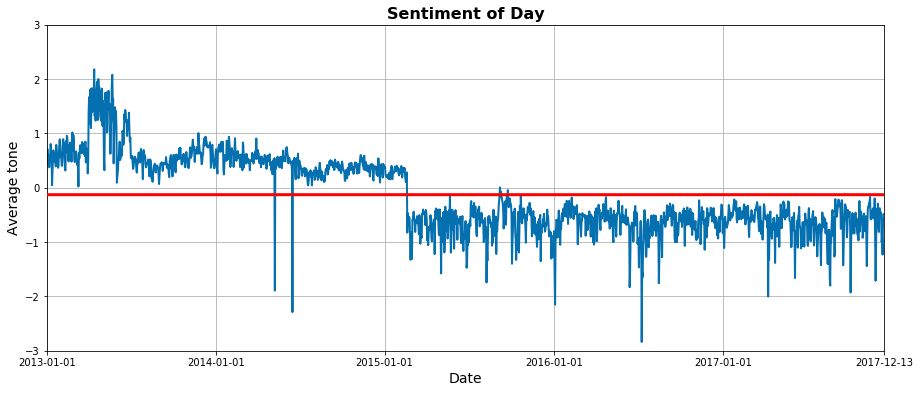

In [0]:
plt.figure(figsize=(15, 6))
plt.grid(zorder=0)
n = len(qSentimentDay["index"])
x_pos = list(range(0,n))
avg = np.mean(np.asarray(qSentimentDay["index"]))
y_avg = [avg]*n
plt.plot(x_pos, qSentimentDay["index"], c='#0570B0', linewidth=2, zorder=2)
plt.plot(x_pos, y_avg, c='r', linewidth=3, zorder=3)
plt.title("Sentiment of Day", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
x_tick = [0, 365, 729, 1094, 1460, n-1]
plt.xticks(x_tick, [qSentimentDay["SQLDATE"][0], qSentimentDay["SQLDATE"][365], qSentimentDay["SQLDATE"][730], qSentimentDay["SQLDATE"][1095], qSentimentDay["SQLDATE"][1461], qSentimentDay["SQLDATE"][n-1]])
plt.ylabel("Average tone", fontsize=14)
plt.ylim([-3, 3])
plt.xlim([0, n-1])

According to this graph, there is irregular oscillation. Before 2015-01-01 the amplitude is a little smaller than that after 2015-01-01. Also, after 2015-01-01 the overall AvgTone is much lower. In addition to that, the AvgTone before 2015-01-01 is genereally positive while the AvgTone after 2015-01-01 is mostly negative. That might have something to do with some important social events.

## Sentiment and Taxi trips

In [0]:
%%bigquery --project $project_id qTripSentiment

SELECT DATE(trip_start_timestamp) as day, COUNT(*) as num_trips, AVG(tt.index) AS sentiment
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` t,
(SELECT FORMAT_TIMESTAMP("%Y-%m-%d", 
PARSE_TIMESTAMP("%Y%m%d", cast(t1.SQLDATE as string) )) AS d,t1.SQLDATE, AVG(t1.NumArticles*ABS(t1.AvgTone)* t1.GoldsteinScale/t2.sumPerMonth)*1000000 AS index
FROM `gdelt-bq.full.events` t1, 
(SELECT MonthYear, SUM( NumArticles) AS sumPerMonth
FROM `gdelt-bq.full.events`
GROUP BY MonthYear) t2
WHERE t1.MonthYear = t2.MonthYear
GROUP BY SQLDATE
ORDER BY SQLDATE ) tt
WHERE DATE(t.trip_start_timestamp) = cast(tt.d as date)
AND trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
AND DATE(trip_start_timestamp) <= '2017-12-31'
GROUP BY day
ORDER BY day

(0, 120000)

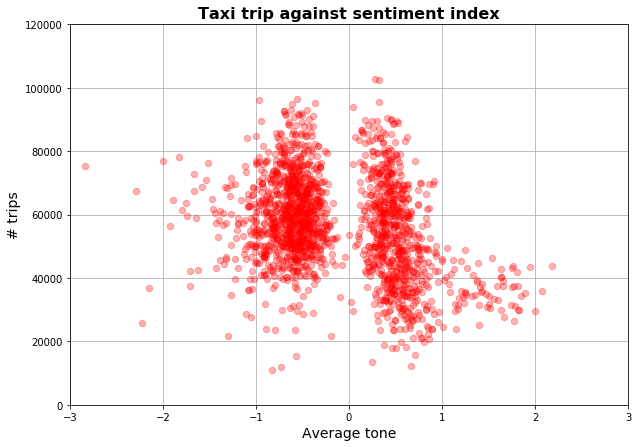

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
plt.scatter(qTripSentiment["sentiment"], qTripSentiment["num_trips"], c='r', alpha=.3, s=40, zorder=2)
plt.title("Taxi trip against sentiment index", fontsize=16, fontweight='bold')
plt.xlabel("Average tone", fontsize=14)
plt.ylabel("# trips", fontsize=14)
plt.xlim([-3, 3])
plt.ylim([0, 120000])

From this graph we can see that whether the tone is negative or positive doesn't play a role in the trip count to a large extent since the tendency is almost symmetric with regard to AvgTone = 0. And if the tone is strong enough, it may lower the trips count in Chicago.

In [0]:
%%bigquery --project $project_id qTipsSentiment

SELECT DATE(trip_start_timestamp) AS day, AVG(tips) AS avgTips, AVG(tt.index) AS sentiment
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` t,
(SELECT FORMAT_TIMESTAMP("%Y-%m-%d", 
PARSE_TIMESTAMP("%Y%m%d", cast(t1.SQLDATE as string) )) AS d, t1.SQLDATE AS date, AVG(t1.NumArticles*ABS(t1.AvgTone)* t1.GoldsteinScale/t2.sumPerMonth)*1000000 AS index
FROM `gdelt-bq.full.events` t1, 
(SELECT MonthYear, SUM( NumArticles) AS sumPerMonth
FROM `gdelt-bq.full.events`
GROUP BY MonthYear) t2
WHERE t1.MonthYear = t2.MonthYear
GROUP BY SQLDATE
ORDER BY SQLDATE ) tt
WHERE DATE(trip_start_timestamp) <= '2017-12-31'
AND trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
AND DATE(t.trip_start_timestamp) = cast(tt.d as date)
GROUP BY day
ORDER BY day

(0.25, 2.5)

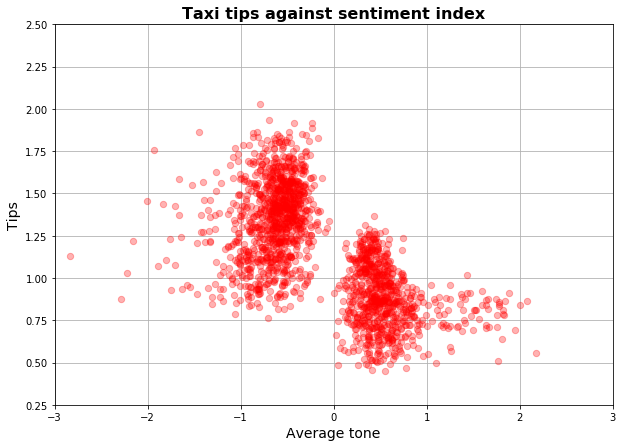

In [0]:
plt.figure(figsize=(10, 7))
plt.grid(zorder=0)
plt.scatter(qTipsSentiment["sentiment"], qTipsSentiment["avgTips"], c='r', alpha=.3, s=40, zorder=2)
plt.title("Taxi tips against sentiment index", fontsize=16, fontweight='bold')
plt.xlabel("Average tone", fontsize=14)
plt.ylabel("Tips", fontsize=14)
plt.xlim([-3, 3])
plt.ylim([0.25, 2.5])

From this graph, we can see that whether the tone is negative or positive does play a role in the tips. Tips under a positive tone are generally lower than that under a negative tone.

---

# Part 4: Data Prediction

 ---

According to previous data analysis, trip count and tips are two of significant components that affect revenues. We selected the following # distinct features which might have influence on the amount of trip count and tips. We would like to evaluate two machine learning models to predict trip count and tips respectively. The labels will be evaluated as 0 (below average) and 1 (above average).

**Model 1 Daily Trip Count**

Features:

*   day of week
*   day of year
*   NO2

**Model 2 Tips**

Features:

*   trip_miles
*   trip_seconds
*   sentiment index


In this section, we will train, evaluate and test our models by using following subsets of our dataset.


*   Training: January 1st 2013 - December 31st 2016
*   Evaluation: January 1st 2017 - June 30th 2017
*   Testing: July 1st 2017 - December 31st 2017


In [0]:
%%bigquery --project $project_id qAvgTripCount

SELECT AVG(cnt) AS avg_cnt
FROM(SELECT COUNT(*) as cnt
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
WHERE DATE(trip_start_timestamp) <= '2016-12-31'
AND trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY DATE(trip_start_timestamp))

In [0]:
qAvgTripCount.head()

,avg_cnt
0,55599.353867


## Model 1 Setup

In [0]:
model_dataset_name = 'trip_count_prediction'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('proj3-sizhuo', 'trip_count_prediction'))

## Model 1 Training
Firstly, only basic features from Chicago taxi trip dataset are selected for training process.

In [0]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `trip_count_prediction.tripcount_model`
OPTIONS(model_type='logistic_reg') AS
SELECT IF(COUNT(*) < 55599, 0, 1) AS label, EXTRACT(DAYOFWEEK FROM trip_start_timestamp) as dayofweek, EXTRACT(DAYOFYEAR FROM trip_start_timestamp) as day
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE DATE(trip_start_timestamp) <= '2016-12-31'
AND trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY DATE(trip_start_timestamp), dayofweek, day

""


In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `trip_count_prediction.tripcount_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,0.634907,0.638543,6.4,6261
1,0,4,0.635882,0.639110,3.2,9141
2,0,3,0.646154,0.648486,1.6,7520
3,0,2,0.663184,0.664571,0.8,5672
4,0,1,0.677995,0.678675,0.4,12488
5,0,0,0.687652,0.687894,0.2,9338


In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `trip_count_prediction.tripcount_model`, (
      SELECT IF(COUNT(*) < 55599, 0, 1) AS label, EXTRACT(DAYOFWEEK FROM trip_start_timestamp) as dayofweek, EXTRACT(DAYOFYEAR FROM trip_start_timestamp) as day
      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE DATE(trip_start_timestamp) >= '2017-01-01'
      AND DATE(trip_start_timestamp) <= '2017-06-30'
      AND trip_miles IS NOT NULL
      AND pickup_community_area IS NOT NULL
      AND dropoff_community_area IS NOT NULL
      AND trip_total IS NOT NULL
      AND company IS NOT NULL
      GROUP BY DATE(trip_start_timestamp), dayofweek, day
  ))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.873239,0.452555,0.535912,0.596154,0.688,0.794863


Merely based on basic temporal features, although achieving comparatively high precision, the initial model has relatively poor accuracy. So, the selected basic features are not sufficient to predict the quantity of daily taxi trips.

## Model 1 Feature Engineering and Re-evaluating
In previous section, NO2 seems to have link with daily trip count, compared with other air quality indicators. Thus, we add NO2 into features to evaluate whether it helps improve the accuracy of our model.

In [0]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `trip_count_prediction.tripcount_model_v2`
OPTIONS(model_type='logistic_reg') AS
SELECT IF(COUNT(*) < 60000, 0, 1) AS label, ROUND(AVG(n.arithmetic_mean)) AS avg_no2, EXTRACT(DAYOFWEEK FROM trip_start_timestamp) as dayofweek, EXTRACT(DAYOFYEAR FROM trip_start_timestamp) as day
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
JOIN `proj3-sizhuo.proj3_chicago_taxi.no2_daily_summary` n
ON DATE(trip_start_timestamp) = n.date_local
WHERE DATE(trip_start_timestamp) <= '2016-12-31'
AND trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
GROUP BY DATE(trip_start_timestamp), dayofweek, day

""


In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `trip_count_prediction.tripcount_model_v2`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,6,0.290334,0.289102,12.8,8513
1,0,5,0.296310,0.294756,6.4,7915
2,0,4,0.326633,0.325694,3.2,5750
3,0,3,0.406222,0.406033,1.6,14022
4,0,2,0.512608,0.512736,0.8,7280
5,0,1,0.602107,0.602240,0.4,5757
6,0,0,0.660153,0.660213,0.2,4394


In [0]:
%%bigquery --project $project_id


  SELECT
  *
FROM
  ML.EVALUATE(MODEL `trip_count_prediction.tripcount_model_v2`, (
      SELECT IF(COUNT(*) < 60000, 0, 1) AS label, ROUND(AVG(n.arithmetic_mean)) AS avg_no2, EXTRACT(DAYOFWEEK FROM trip_start_timestamp) as dayofweek, EXTRACT(DAYOFYEAR FROM trip_start_timestamp) as day
      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      JOIN `proj3-sizhuo.proj3_chicago_taxi.no2_daily_summary` n
      ON DATE(trip_start_timestamp) = n.date_local
      WHERE DATE(trip_start_timestamp) >= '2017-01-01'
      AND DATE(trip_start_timestamp) <= '2017-06-30'
      AND trip_seconds IS NOT NULL
      AND trip_miles IS NOT NULL
      AND pickup_community_area IS NOT NULL
      AND dropoff_community_area IS NOT NULL
      AND trip_total IS NOT NULL
      AND company IS NOT NULL
      GROUP BY DATE(trip_start_timestamp), dayofweek, day
  ))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.994475,1.0,0.994475,0.99723,0.135287,0.945945


Surprisingly, after incorporating NO2 data into features, the model's accuracy improves significantly. Other statistical indicators also fall into reasonable ranges. Thus, the combination of temporal characteristics and daily NO2 concentration would be a relatively accurate model to predict whether there will be more taxi trips or fewer for a day.

## Model 1 Evaluate Final Model on Test Set

In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `trip_count_prediction.tripcount_model_v2`, (
      SELECT IF(COUNT(*) < 60000, 0, 1) AS label, ROUND(AVG(n.arithmetic_mean)) AS avg_no2, EXTRACT(DAYOFWEEK FROM trip_start_timestamp) as dayofweek, EXTRACT(DAYOFYEAR FROM trip_start_timestamp) as day
      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      JOIN `proj3-sizhuo.proj3_chicago_taxi.no2_daily_summary` n
      ON DATE(trip_start_timestamp) = n.date_local
      WHERE DATE(trip_start_timestamp) >= '2017-07-01'
      AND DATE(trip_start_timestamp) <= '2017-12-31'
      AND trip_seconds IS NOT NULL
      AND trip_miles IS NOT NULL
      AND pickup_community_area IS NOT NULL
      AND dropoff_community_area IS NOT NULL
      AND trip_total IS NOT NULL
      AND company IS NOT NULL
      GROUP BY DATE(trip_start_timestamp), dayofweek, day
  ))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.972826,1.0,0.972826,0.986226,0.13962,0.651594


The evaluation on test set validates the relatively high accuracy of our model.

## Model 2 Setup

In [0]:
model_dataset_name = 'tips_prediction'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

## Model 2 Training

Firstly, only basic features from our dataset are selected for training process.

In [0]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `tips_prediction.tips_model`
OPTIONS(model_type='logistic_reg') AS
SELECT IF(tips < 1, 0, 1) AS label, trip_miles, trip_seconds
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` t
WHERE DATE(trip_start_timestamp) <= '2016-12-31'
AND trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL

""


In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `tips_prediction.tips_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,0.624498,0.624753,6.4,65221
1,0,4,0.625720,0.625705,3.2,58788
2,0,3,0.637863,0.637714,1.6,55708
3,0,2,0.657944,0.657797,0.8,54177
4,0,1,0.675330,0.675237,0.4,64596
5,0,0,0.686670,0.686633,0.2,41477


In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `tips_prediction.tips_model`, (
      SELECT IF(tips < 1, 0, 1) AS label, trip_miles, trip_seconds
      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` t
      WHERE DATE(trip_start_timestamp) >= '2017-01-01'
      AND DATE(trip_start_timestamp) <= '2017-06-30'
      AND trip_seconds IS NOT NULL
      AND trip_miles IS NOT NULL
      AND pickup_community_area IS NOT NULL
      AND dropoff_community_area IS NOT NULL
      AND trip_total IS NOT NULL
      AND company IS NOT NULL
  ))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.651382,0.103797,0.596552,0.179061,0.687341,0.607486


## Model 2 Feature Engineering and Re-evaluating

Here we add average daily sentiment index into features to find whether it helps to predict taxi tips.

In [0]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `tips_prediction.tips_model_v2`
OPTIONS(model_type='logistic_reg') AS
SELECT IF(tips < 1, 0, 1) AS label, trip_miles, trip_seconds, tt.index AS sentiment
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` t,
(SELECT FORMAT_TIMESTAMP("%Y-%m-%d", 
PARSE_TIMESTAMP("%Y%m%d", cast(t1.SQLDATE as string) )) AS d, t1.SQLDATE AS date, AVG(t1.NumArticles*ABS(t1.AvgTone)* t1.GoldsteinScale/t2.sumPerMonth)*1000000 AS index
FROM `gdelt-bq.full.events` t1, 
(SELECT MonthYear, SUM( NumArticles) AS sumPerMonth
FROM `gdelt-bq.full.events`
GROUP BY MonthYear) t2
WHERE t1.MonthYear = t2.MonthYear
GROUP BY SQLDATE
ORDER BY SQLDATE ) tt
WHERE DATE(trip_start_timestamp) <= '2016-12-31'
AND trip_seconds IS NOT NULL
AND trip_miles IS NOT NULL
AND pickup_community_area IS NOT NULL
AND dropoff_community_area IS NOT NULL
AND trip_total IS NOT NULL
AND company IS NOT NULL
AND DATE(t.trip_start_timestamp) = cast(tt.d as date)

""


In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `tips_prediction.tips_model_v2`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,5,0.619620,0.621570,6.4,71579
1,0,4,0.621088,0.622786,3.2,86048
2,0,3,0.634070,0.635133,1.6,90279
3,0,2,0.655454,0.656003,0.8,111399
4,0,1,0.674041,0.674275,0.4,72933
5,0,0,0.686196,0.686263,0.2,55415


In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `tips_prediction.tips_model_v2`, (
      SELECT IF(tips < 1, 0, 1) AS label, trip_miles, trip_seconds, tt.index AS sentiment
      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` t,
      (SELECT FORMAT_TIMESTAMP("%Y-%m-%d", 
      PARSE_TIMESTAMP("%Y%m%d", cast(t1.SQLDATE as string) )) AS d, t1.SQLDATE AS date, AVG(t1.NumArticles*ABS(t1.AvgTone)* t1.GoldsteinScale/t2.sumPerMonth)*1000000 AS index
      FROM `gdelt-bq.full.events` t1, 
      (SELECT MonthYear, SUM( NumArticles) AS sumPerMonth
      FROM `gdelt-bq.full.events`
      GROUP BY MonthYear) t2
      WHERE t1.MonthYear = t2.MonthYear
      GROUP BY SQLDATE
      ORDER BY SQLDATE ) tt
      WHERE DATE(trip_start_timestamp) >= '2017-01-01'
      AND DATE(trip_start_timestamp) <= '2017-06-30'
      AND trip_seconds IS NOT NULL
      AND trip_miles IS NOT NULL
      AND pickup_community_area IS NOT NULL
      AND dropoff_community_area IS NOT NULL
      AND trip_total IS NOT NULL
      AND company IS NOT NULL
      AND DATE(t.trip_start_timestamp) = cast(tt.d as date)
  ))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.638509,0.138613,0.601594,0.227778,0.676839,0.596263


Evaluation indicates that the addition of sentiment index does make a small difference on accuracy and precision.

## Model 2 Evaluate Final Model on Test Set

In [0]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `tips_prediction.tips_model_v2`, (
      SELECT IF(tips < 1, 0, 1) AS label, trip_miles, trip_seconds, tt.index AS sentiment
      FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` t,
      (SELECT FORMAT_TIMESTAMP("%Y-%m-%d", 
      PARSE_TIMESTAMP("%Y%m%d", cast(t1.SQLDATE as string) )) AS d, t1.SQLDATE AS date, AVG(t1.NumArticles*ABS(t1.AvgTone)* t1.GoldsteinScale/t2.sumPerMonth)*1000000 AS index
      FROM `gdelt-bq.full.events` t1, 
      (SELECT MonthYear, SUM( NumArticles) AS sumPerMonth
      FROM `gdelt-bq.full.events`
      GROUP BY MonthYear) t2
      WHERE t1.MonthYear = t2.MonthYear
      GROUP BY SQLDATE
      ORDER BY SQLDATE ) tt
      WHERE DATE(trip_start_timestamp) >= '2017-07-01'
      AND DATE(trip_start_timestamp) <= '2017-12-31'
      AND trip_seconds IS NOT NULL
      AND trip_miles IS NOT NULL
      AND pickup_community_area IS NOT NULL
      AND dropoff_community_area IS NOT NULL
      AND trip_total IS NOT NULL
      AND company IS NOT NULL
      AND DATE(t.trip_start_timestamp) = cast(tt.d as date)
  ))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.627467,0.152622,0.607229,0.245524,0.673939,0.586174


---

# Part 5: Conclusion

---

---

*TODO: Final conclusions based on the rest of your project*

---

In this project, we analyzed some basic features including time, location, company etc and how they impact the trips count and tips in Chicago. In addition to that, we added and explored some extra features that might have an influence on trips count and tips in Chicago including NO2, SO2, PM2.5, PM10, and people's sentiment. It turns out that company, time, NO2 might have an influence(the influence of NO2 seems not that distinct though)on trips count and people's sentiment might have an influence on tips.

Ultimately in the prediction part, in model 1 which aims to predict trips count in Chicago, our basic feature is dayOfYear and dayOfWeek while our add feature is NO2 daily concentration. From the model training result we can see that our added feature achieved a distinct improvement in accuracy from 53.79% to 97.28%, which indicates that NO2 daily concentraion plays an important role in predicting the trip counts. In model 2 which aims to predict tips in a trip in Chicago, our basic feature is trip distance and trip seconds while our added feature is people's sentiment. From the model training result we can see that our added feature led to a small improvement of accuracy from 59.66% to 60.72%, which indicates that sentiment might not have much relevance to how much the tip is in a trip.

If given more time and more data, we would like to explore if attributes of passenger or driver (such as gender, age, job etc)might have an influence on trips count and tips in Chicago.